# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
# First let's get some info
df_offers.info()
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


It looks like the datasets are already cleaned up and contain no null values. The types look fine as well. In the next step we'll create a matrix using customers as observations (rows) and offers as features (columns).

In [5]:
# Merge df_offers and df_transactions on offer_id
df_all = df_transactions.merge(df_offers,on='offer_id',how='left')
df = df_all.loc[:,['customer_name','offer_id','n']]
# Pivot DataFrame, Fill Null Values and use Integers
df_pivot = df.pivot(index='customer_name',columns='offer_id',values='n').fillna(0).astype(int)
df_pivot.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

The Sum-of-Squares method is an indicator of all the distances to their cluster's center. The extremes are worthless to us (i.e. very high numbers and 0). Minimization is an initial goal but it is not absolute. If we were simply interested to minimize we could reduce any data set to 0 (i.e. each data point is it's own cluster), but this would be essentially the same as overfitting in supervised algorithms and would have little value to us. As an indicator of the optimal number of clusters we look at the differences between clusters and the improvement in distances, once we don't make *relevant* improvements in distance anymore we should stop. Hence, there is a certain amount of subjectivity in deciding what is the best number for the Sum-of-Squares Method.

In [6]:
# Create a numpy matrix 
x_cols = np.matrix(df_pivot.values)

from scipy.sparse import csr_matrix

csr_mat = csr_matrix(df_pivot.values)
type(x_cols[(0,0)])

numpy.int64

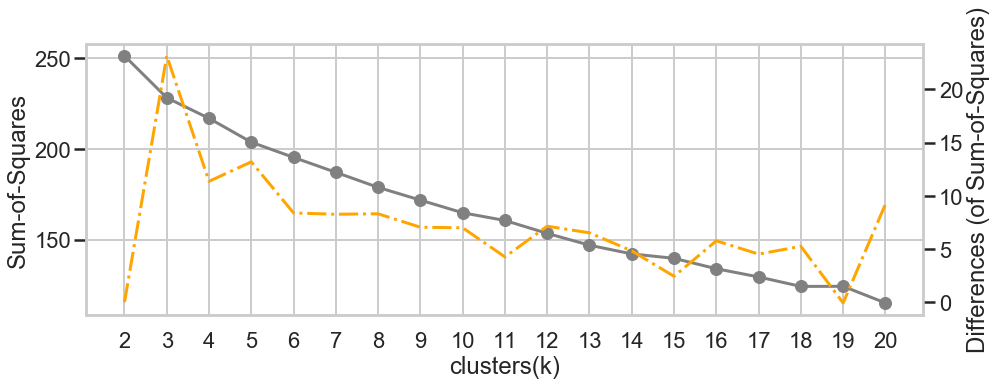

In [7]:
from sklearn.cluster import KMeans

ks = [int(k) for k in np.linspace(2,20,19)]
inertias = []

for k in ks:
    km = KMeans(n_clusters=k,random_state=42)
    km.fit(x_cols)
    inertias.append(km.inertia_)

inertias = np.array(inertias)
diff = inertias[:-1] - inertias[1:]
diff_0 = np.insert(diff,0,0)

fig = plt.figure(figsize=(15,5))
_ = plt.plot(ks,inertias,'-o',c='gray')
_ = plt.xlabel('clusters(k)')
_ = plt.ylabel('Sum-of-Squares')
_ = plt.xticks(ks)

_ = plt.twinx()
_ = plt.plot(ks,diff_0,'-.',c='orange')
_ = plt.ylabel('Differences (of Sum-of-Squares)')
_ = plt.grid(False)

In addition to the inertias I plotted the differences between k and k-1 inertias. This seemed necessary as there is no clear Elbow visible. Looking at the diff plot we can see that there is a big difference in Sum-of-Squares from 2 to 3 clusters and it starts to slow already at 4 clusters until the differences slowly flatten out around 6 clusters. For the rest of this analysis we'll use 5 clusters right before the differences flatten to less than 10 with each additional cluster.

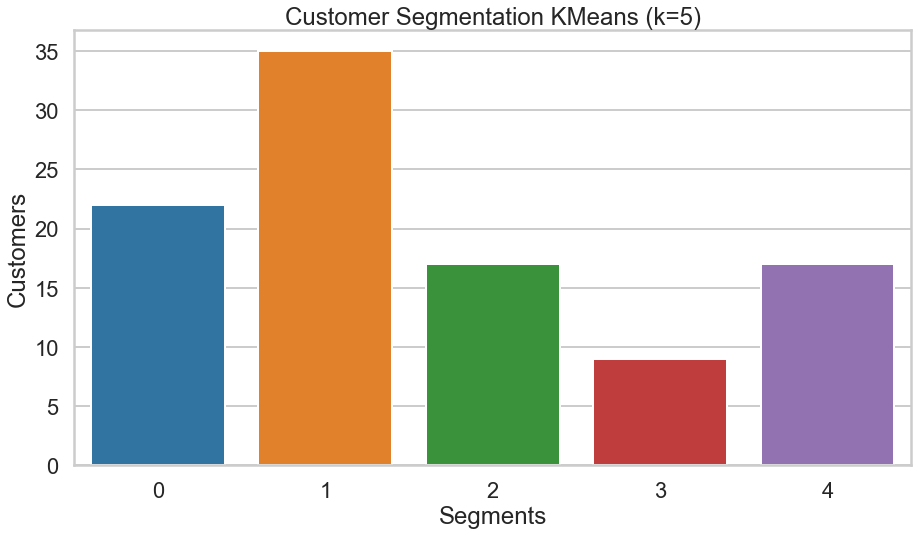

In [54]:
best_k = 5

km_best = KMeans(n_clusters=best_k,random_state=42)
km_best.fit(x_cols)

labels_best = km_best.predict(x_cols)

fig = plt.figure(figsize=(15,8))
_ = sns.countplot(labels_best)
_ = plt.xlabel('Segments')
_ = plt.ylabel('Customers')
_ = plt.title('Customer Segmentation KMeans (k=5)')

The biggest challenge using the Elbow Method was finding the 'Elbow' as there was no clear distinction between rapidly decreasing distances and slowing of the same. Instead, the improvements in Sum-of-Squares started to be relatively small after only 3 clusters with sum-of-square measures decreasing almost linearly after 5 clusters.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

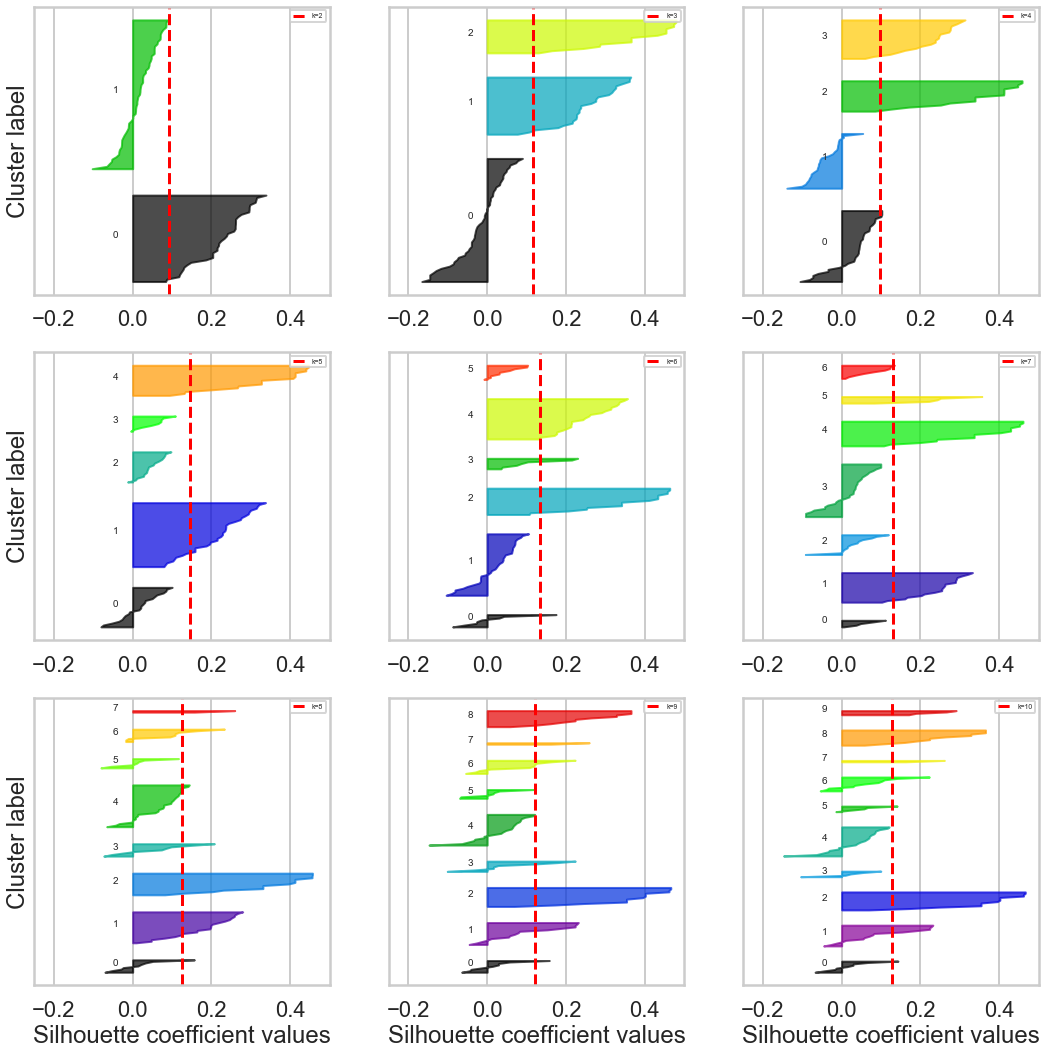

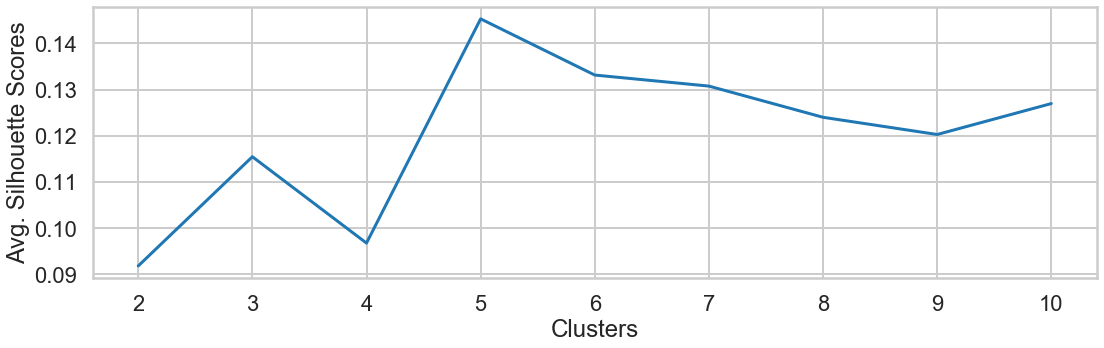

In [55]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]


ks = [int(k) for k in np.linspace(2,10,9)]
avg_silhouette_scores = []

col_subplots = 3
row_subplots = int(len(ks) / col_subplots)
if (len(ks) % col_subplots) != 0:
    row_subplots = row_subplots + 1
    
fig, ax = plt.subplots(row_subplots, col_subplots,figsize=(18,18))

switch = 0
for i,k in enumerate(ks):
    subplot_i = int(i/col_subplots)
    
    # The silhouette coefficient can range from -1, 1 but in this case all lie within [-0.25, 0.5]
    ax[subplot_i][switch].set_xlim([-0.25, 0.5])
    
    km = KMeans(n_clusters=k,random_state=42)
    km.fit(x_cols)
    labels = km.predict(x_cols)

    silhouette_avg = silhouette_score(x_cols, labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax[subplot_i][switch].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax[subplot_i][switch].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    if subplot_i == (row_subplots - 1):
        ax[subplot_i][switch].set_xlabel("Silhouette coefficient values")
    if switch == 0:
        ax[subplot_i][switch].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax[subplot_i][switch].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[subplot_i][switch].set_yticks([])  # Clear the yaxis labels / ticks
    _ = ax[subplot_i][switch].legend(labels=['k={}'.format(k)],loc='upper right',fontsize='x-small')
    
    avg_silhouette_scores.append(silhouette_avg)
    
    if switch < (col_subplots - 1):
        switch = switch + 1
    else:
        switch = 0
        
plt.show()

fig = plt.figure(figsize=(18,5))
_ = plt.plot(ks,avg_silhouette_scores)
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Avg. Silhouette Scores')
plt.show()

If we simply take the highest Average Silhouette Score there is no obvious difference between the 'Elbow' method and the Silhouette method in this case. Both suggest 5 clusters as the optimum, if anything the Silhouette method is slightly more clear about it being a good choice. Nevertheless, looking at the actual silhouettes coefficient values and comparing them, we can see an imbalance in the quality of clustering. Cluster 1 and 4 are much larger and are the only clusters that are actually above the average, clusters 0,2 and 3 are way below the average and 0 has quite a few points that are possibly in the wrong cluster.

Looking at the silhouettes, an 8 cluster solution looks quite possible as well. We'd have much smaller individual groups but all clusters reach (or are fairly close to) the average silhouette score (which is slightly lower than the maximum).

In general, the Silhouette coefficient values are quite low (<0.25) indicating that there are no substantial structures, this issue is graver in the higher cluster solution (k=8) compared to the lower cluster solution (k=5) but is present in all solutions of this clustering..

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

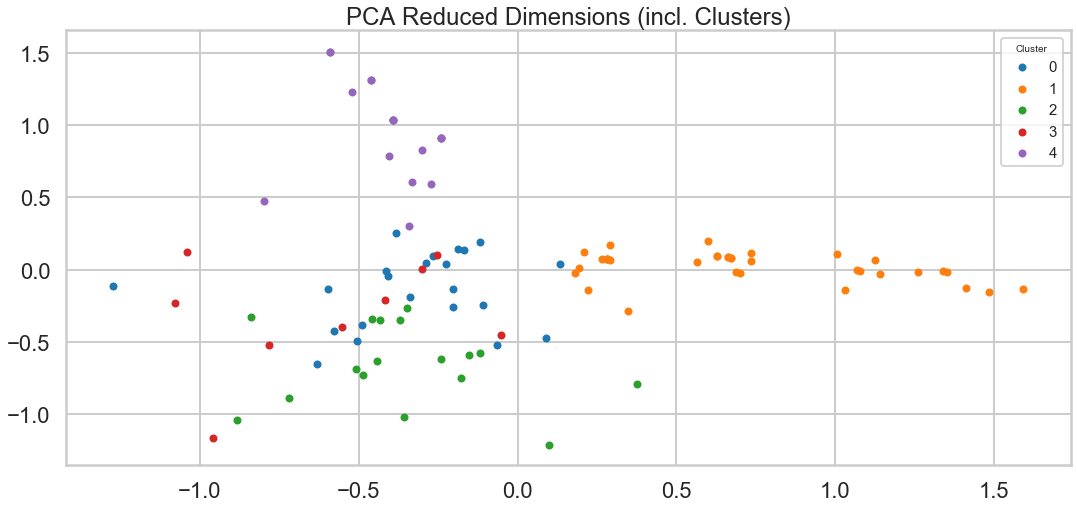

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(x_cols)
transformed = pca.transform(x_cols).T
transformed_clusters = pd.DataFrame({'x': transformed[0],'y': transformed[1],'customer_name': df_pivot.index,'cluster_id': labels_best})

fig = plt.figure(figsize=(18,8))
    
def plot_pca(transformed_clusters):

    lgd_labels = sorted(transformed_clusters['cluster_id'].unique())

    for label in lgd_labels:
        x = transformed_clusters.loc[transformed_clusters['cluster_id'] == label,'x']
        y = transformed_clusters.loc[transformed_clusters['cluster_id'] == label,'y']

        _ = plt.scatter(x,y,label=label,marker='.')

    _ = plt.legend(loc="upper right", title="Cluster",fontsize=15)
    _ = plt.title('PCA Reduced Dimensions (incl. Clusters)')

plot_pca(transformed_clusters)



What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

We can see that the previous observation of a low silhouette coefficient is showing here as well. This is especially visible in Cluster 3 (red) which looks like incoherent red dots inside of clusters 0 and 2, which in turn look like one and the same Cluster. Judging from this graphic, it looks like 3 might be a better cluster amount. Visually the 'Elbow' Method was closer to this last method of identifying distances. Avg. Silhouette Scores were misleading and Coefficient Value Plots (if nice to look at and providing some additional detail) were unclear in this case and less intuitive than this last scatter plot using PCA.

Available Columns:
customer_name <class 'str'>
offer_id <class 'str'>
n <class 'str'>
campaign <class 'str'>
varietal <class 'str'>
min_qty <class 'str'>
discount <class 'str'>
origin <class 'str'>
past_peak <class 'str'>
cluster_id <class 'str'>
type <class 'str'>
discount_range <class 'str'>


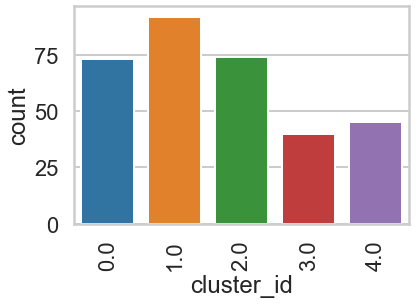

In [57]:
for cluster_id in transformed_clusters['cluster_id']:
    cluster_cust = transformed_clusters.loc[transformed_clusters['cluster_id'] == cluster_id,'customer_name']
    df_all.loc[df_all['customer_name'].isin(cluster_cust),'cluster_id'] = int(cluster_id)

df_all.sort_values(by=['cluster_id'])
_ = sns.countplot(df_all.cluster_id)
_ = plt.xticks(rotation=90)

print('Available Columns:')
for col in df_all.columns:
    print(col,type(col))

First of all I'd like to know more about the types of wine that these clusters seem to order.

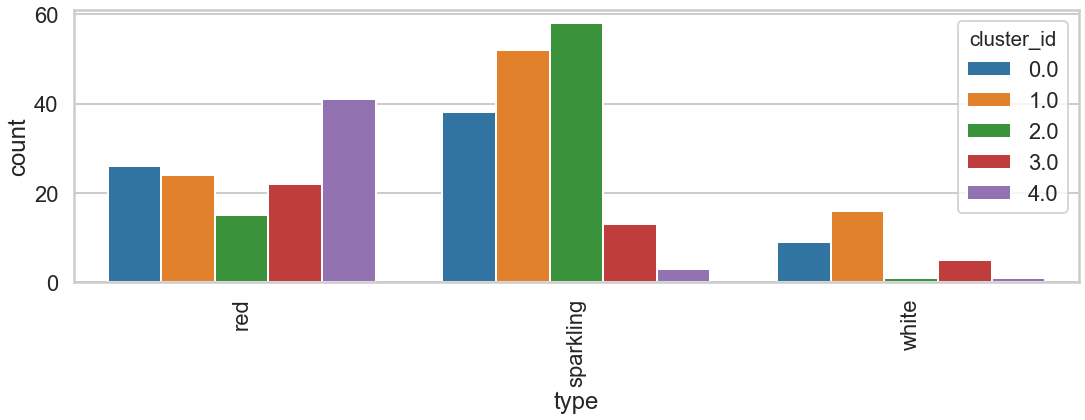

In [79]:
df_all.loc[df_all['varietal'].isin(['Espumante','Champagne','Prosecco']),'type'] = 'sparkling'
df_all.loc[df_all['varietal'].isin(['Pinot Noir','Malbec','Merlot','Cabernet Sauvignon']),'type'] = 'red'
df_all.loc[df_all['varietal'].isin(['Chardonnay','Pinot Grigio']),'type'] = 'white'

fig = plt.figure(figsize=(18,5))
_ = sns.countplot('type',data=df_all,hue='cluster_id')
_ = plt.xticks(rotation=90)

We can see that cluster 4 is almost exclusively ordering red wine and cluster 2 while ordering some red wine is ordering a lot of sparkling wine.

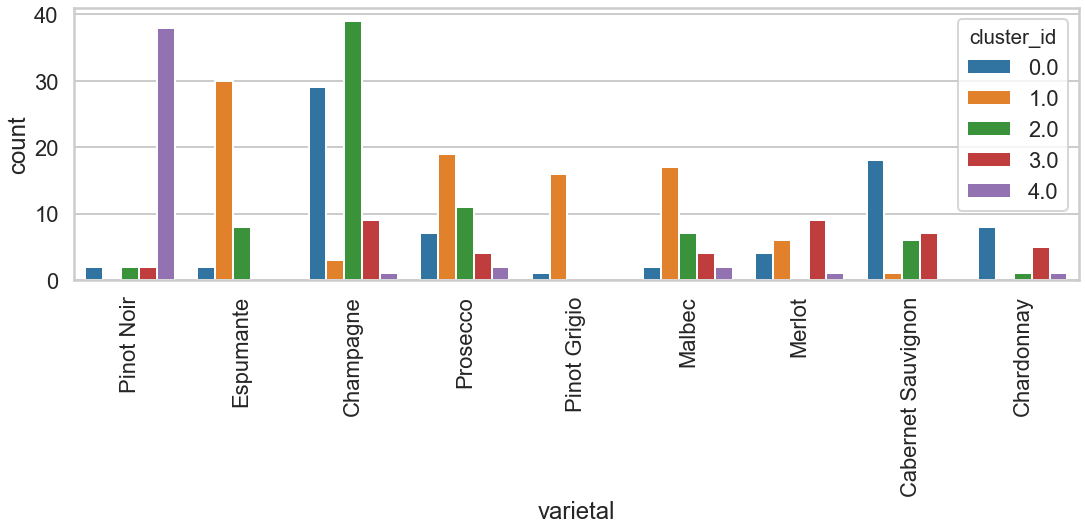

In [60]:
fig = plt.figure(figsize=(18,5))
_ = sns.countplot('varietal',data=df_all,hue='cluster_id')
_ = plt.xticks(rotation=90)

Cluster 4 is predominantly ordering not just red wine but specifically Pinot Noir, while Cluster 2 is ordering a lot of Champagne. We should keep this in mind for the analysis further down, let's have a look whether these observations have a relationship to any specific offer.

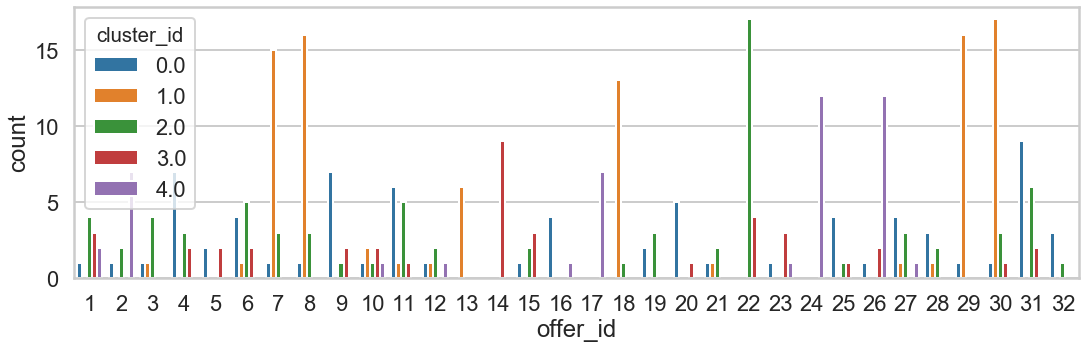

In [61]:
fig = plt.figure(figsize=(18,5))
_ = sns.countplot('offer_id',hue='cluster_id', data=df_all)

Stand-out offers for different clusters that reached more than 10 orders:
- Cluster 1 includes offers 7,8,18,29 and 30
- Cluster 2 includes offer 22
- Cluster 4 includes offers 24 and 26

In [62]:
df_all.loc[df_all['offer_id'].isin([7,8,18,29,30]),:].head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster_id,type,discount_range
5,Williams,18,1,July,Espumante,6,50,Oregon,False,2.0,sparkling,50.0
8,Brown,7,1,March,Prosecco,6,40,Australia,True,1.0,sparkling,40.0
9,Brown,29,1,November,Pinot Grigio,6,87,France,False,1.0,white,90.0
10,Brown,30,1,December,Malbec,6,54,France,False,1.0,red,60.0
11,Jones,8,1,March,Espumante,6,45,South Africa,False,1.0,sparkling,50.0


We can see that `min_qty` is 6 for all our test outputs let's see if min_qty is a good predictor for this cluster.

In [63]:
df_all.loc[df_all['offer_id'].isin([22]),:].head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster_id,type,discount_range
6,Williams,22,1,August,Champagne,72,63,France,False,2.0,sparkling,70.0
16,Miller,22,1,August,Champagne,72,63,France,False,3.0,sparkling,70.0
20,Davis,22,1,August,Champagne,72,63,France,False,2.0,sparkling,70.0
54,Jackson,22,1,August,Champagne,72,63,France,False,2.0,sparkling,70.0
60,White,22,1,August,Champagne,72,63,France,False,3.0,sparkling,70.0


Cluster 2 might have an affinity for Champagne. This could be worth testing out as this cluster doesn't seem to respond strongly to other offers.

In [64]:
df_all.loc[df_all['offer_id'].isin([24,26]),:].head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster_id,type,discount_range
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False,4.0,red,40.0
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False,4.0,red,40.0
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False,4.0,red,90.0
25,Rodriguez,26,1,October,Pinot Noir,144,83,Australia,False,4.0,red,90.0
31,Anderson,24,1,September,Pinot Noir,6,34,Italy,False,4.0,red,40.0


As expected Cluster 4 responded well to a Pinot Noir offer.

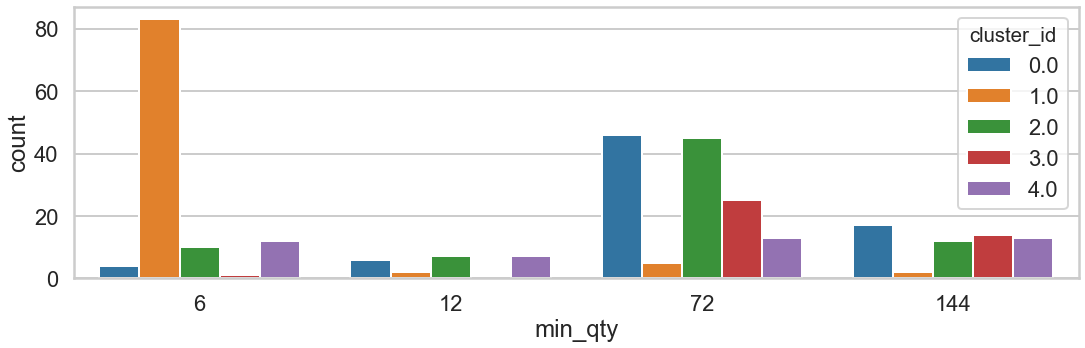

In [65]:
fig = plt.figure(figsize=(18,5))
_ = sns.countplot('min_qty',hue='cluster_id', data=df_all)

We were correct Cluster 1 generally puts in orders when offers require low minimum quantities (6). Cluster 3 on the other hand only seem to order wines that have a minimum of 72 or more. It should also be noticed that most orders for Cluster 0 and 2 are in the 72 minimum quantity range.

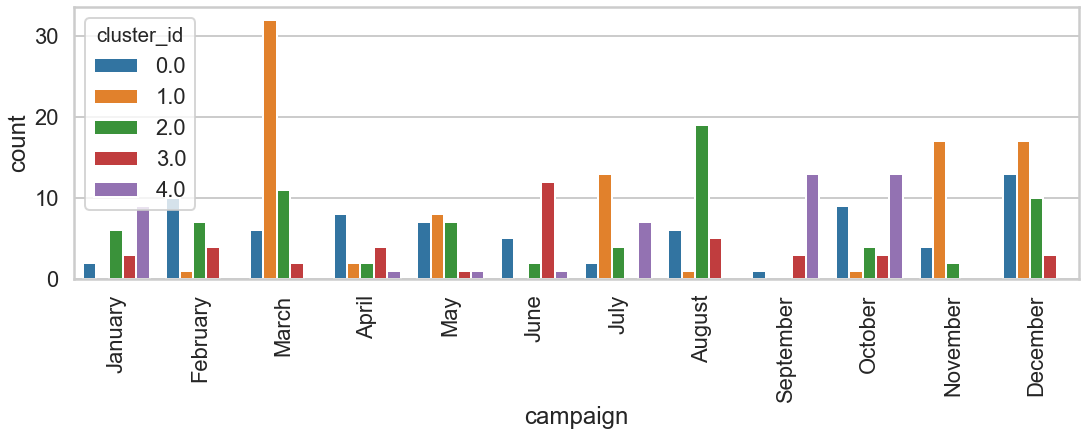

In [66]:
fig = plt.figure(figsize=(18,5))
_ = sns.countplot('campaign',order=['January','February','March','April','May','June','July','August','September','October','November','December'],hue='cluster_id', data=df_all)
_ = plt.xticks(rotation=90)

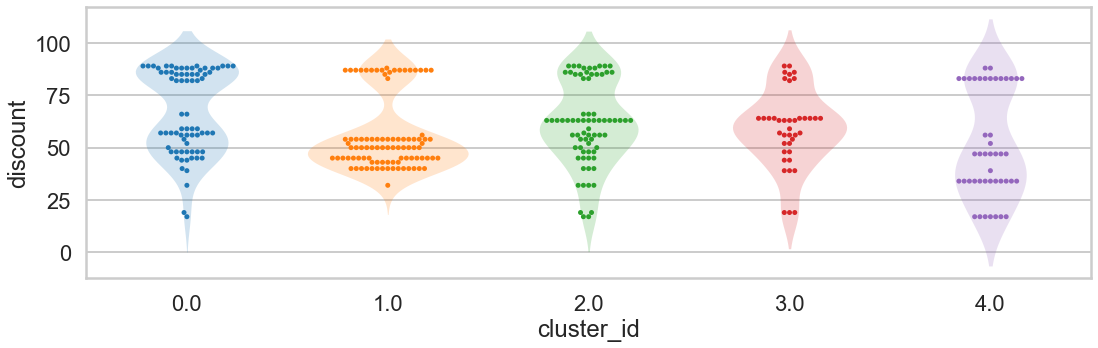

In [139]:
fig, ax = plt.subplots(1,1,figsize=(18,5))
_ = sns.violinplot('cluster_id','discount',saturation=1,width=.8,linewidth=0,inner=None,data=df_all)
for pc in ax.collections:
    pc.set_alpha(0.2)
_ = sns.swarmplot('cluster_id','discount',data=df_all)

I can't find a clear pattern for the different clusters here.

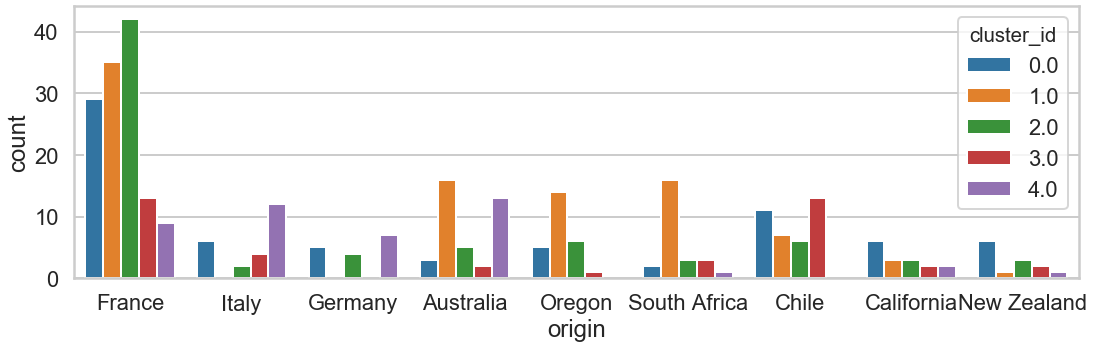

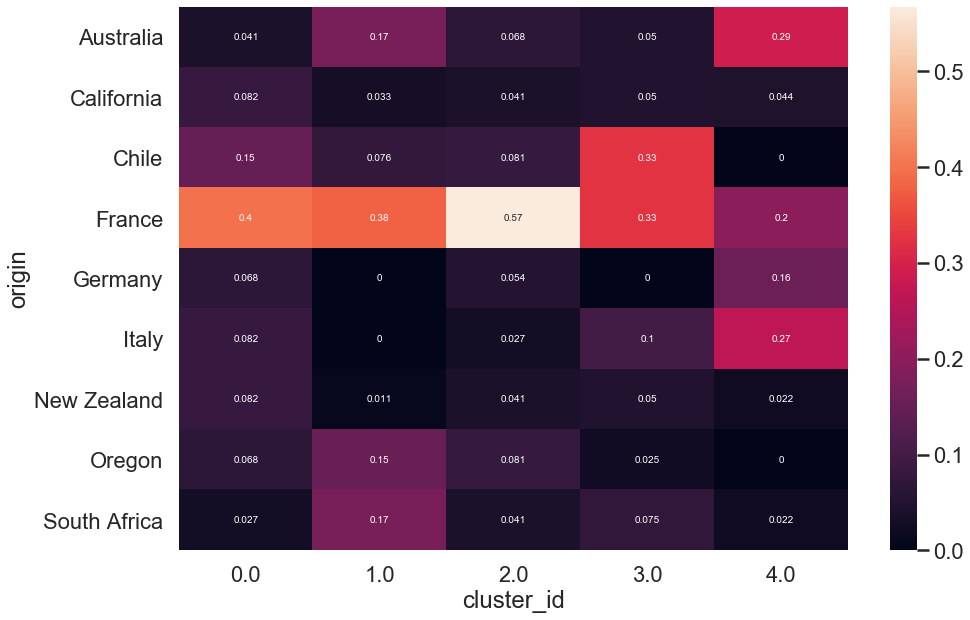

In [78]:
fig = plt.figure(figsize=(18,5))
_ = sns.countplot('origin',hue='cluster_id', data=df_all)

def relative_column_vals(col):
    return col / col.sum()

ct_origin = pd.crosstab(df_all['origin'],df_all['cluster_id'])
ct_origin = ct_origin.apply(relative_column_vals)
fig = plt.figure(figsize=(15,10))
_ = sns.heatmap(ct_origin, annot=True)
plt.show()

France is generally one of the regions that are ordered more than others but we can also see that Cluster 2 seems to have a taste for French wine. From a previous plot we know that one of the most successful campaigns for this cluster was a French Champagne so this might heavily influence the dominance of the French origin in Cluster 2. 

In conclusion, it was not unexpected that we didn't learn much about Cluster 3. In the plot we've seen that Cluster 3 was widely spread across Cluster 0 and 2 without any visible cohesion. The clearest clustering results were generated for the two "legs" (i.e. Cluster 1 and 4). Cluster 1 seem to respond best to smaller minimum quantities and Cluster 4 is a fan of Pinot Noir. This is quite a lot of interesting insights for such a small sample. There were also some unusual patterns for Cluster 2 and a Champagne offer that did very well with that group. A lot of interesting material for further investigation and testing.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

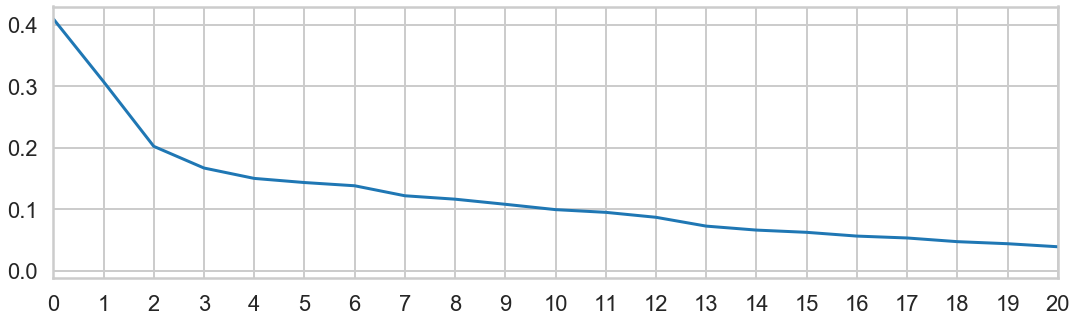

In [80]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

fig = plt.figure(figsize=(18,5))
_ = plt.plot(range(len(pca.explained_variance_)),pca.explained_variance_)
_ = plt.xlim(0,20)
_ = plt.xticks(range(21))

One optimal number the PCA Explained Variance metric suggests is 2 as the explained variance sharply flattens for x > 2.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Ward's Method is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendrogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendrogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


-- Affinity Propagation --
Estimated number of clusters: 3
-- Spectral Clustering --
Estimated number of clusters: 5
-- Agglomerative Clustering --
Estimated number of clusters: 5
-- DBSCAN Clustering --
Estimated number of components: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0

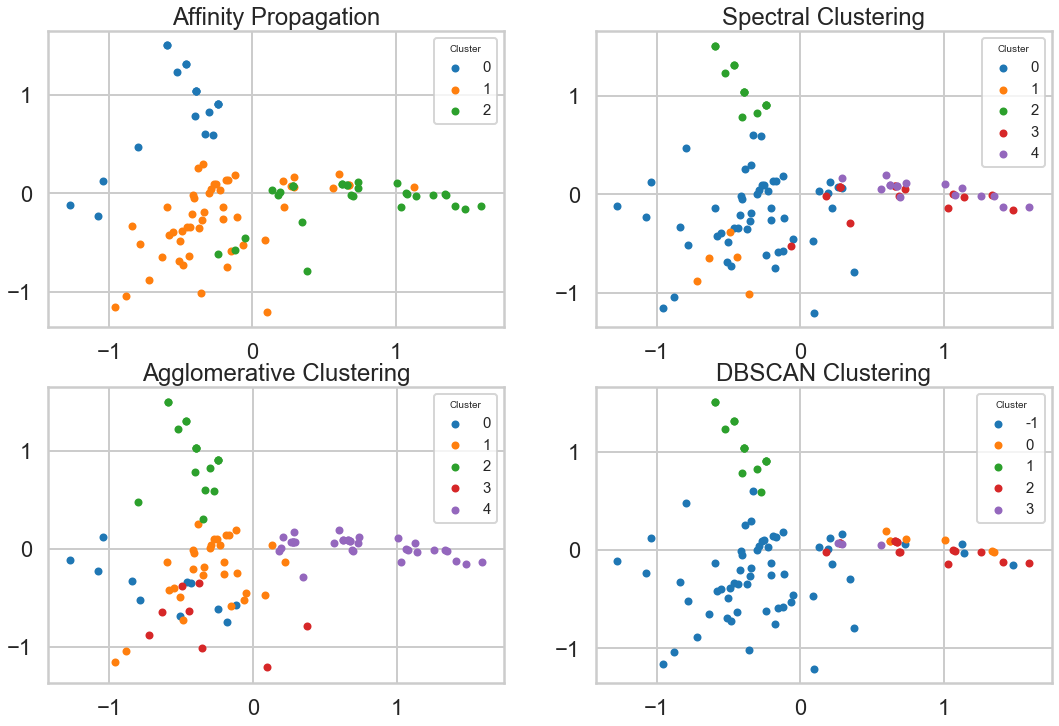

In [141]:
# 1. Affinity Propagation
from sklearn.cluster import AffinityPropagation

# Common defaults for damping (0.5 >= damping < 1) and unless there is a priori knowledge preference should start at -25
# More info on this algorithm https://www.ritchievink.com/blog/2018/05/18/algorithm-breakdown-affinity-propagation/
af = AffinityPropagation(damping=0.5,preference=-30).fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('-- Affinity Propagation --')
print('Estimated number of clusters: {}'.format(n_clusters_))

fig, ax = plt.subplots(2,2,figsize=(18,12))
_ = plt.subplot(2,2,1)
transformed_clusters = pd.DataFrame({'x': transformed[0],'y': transformed[1],'cluster_id': labels})
_ = plot_pca(transformed_clusters)
_ = plt.title('Affinity Propagation')


# 2. Spectral clustering
from sklearn.cluster import SpectralClustering

# 1. By default we're creating an affinity matrix using 'rbf' and gamma as a tuning parameter 
# (these can be replaced by nearest neighbors and n_neighbors or be precomputed)
# 2. 'assign_labels' defines the algorithm to find clusters in the data
# NOTE: n_clusters is an optional parameter but it performs better if known
sc = SpectralClustering(n_clusters=5, affinity='rbf', gamma=1, assign_labels='kmeans',random_state=42)
sc.fit(x_cols)
n_clusters_ = sc.n_clusters
labels = sc.labels_

print('-- Spectral Clustering --')
print('Estimated number of clusters: {}'.format(n_clusters_))

_ = plt.subplot(2,2,2)
transformed_clusters = pd.DataFrame({'x': transformed[0],'y': transformed[1],'cluster_id': labels})
_ = plot_pca(transformed_clusters)
_ = plt.title('Spectral Clustering')


# 3. Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

# This option can also create a full tree 
# NOTE: n_clusters is an optional parameter
aggc = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
aggc.fit(x_cols)
n_clusters_ = aggc.n_clusters
labels = aggc.labels_

print('-- Agglomerative Clustering --')
print('Estimated number of clusters: {}'.format(n_clusters_))

_ = plt.subplot(2,2,3)
transformed_clusters = pd.DataFrame({'x': transformed[0],'y': transformed[1],'cluster_id': labels})
_ = plot_pca(transformed_clusters)
_ = plt.title('Agglomerative Clustering')


# 4. DBSCAN Clustering
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.4, min_samples=5, metric='euclidean')
dbscan.fit(x_cols)
n_components = dbscan.components_ 
labels = dbscan.labels_

print('-- DBSCAN Clustering --')
print('Estimated number of components: {}'.format(n_components))

_ = plt.subplot(2,2,4)
transformed_clusters = pd.DataFrame({'x': transformed[0],'y': transformed[1],'cluster_id': labels})
_ = plot_pca(transformed_clusters)
_ = plt.title('DBSCAN Clustering')

It looks like the challenge here was to properly identify the two 'legs' and the blob in the lower left corner (seen in the PCA reduced dimensions). Additionally, we know from the above analysis that it is likely that there are between 3 and 5 possible clusters. This is also backed up by the number of data points: Since there are only 100 customers any cluster number above that would make detection of clusters difficult due to too few data points in each cluster.

We can see that DBSCAN and Affinity Propagation are having more trouble finding the second 'leg' (i.e. the horizontal one). The most stable cluster seems to be the verticle 'leg'. The Agglomerative Clustering Algorithm seems to have been the most successful at identifying the two legs. As our analysis above has shown the Cluster in the III. Quadrant could actually be fabricated and not be very stable. The cluster 2 and 4 (i.e. in Agglomerative Clustering) do correspond well with the clusters found in the K-Means clustering that showed some unique and actionable features.